In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

* Download the dataset
* Read the data information
* Read the description of dataset

In [237]:
data = pd.read_csv('finaltask.csv')
data.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [238]:
data.isna().sum()

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                  14
Credit_History        50
Area                   0
Status                 0
dtype: int64

In [239]:
data.Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Term, dtype: int64

#### Removing outliers

In [240]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return column[(column >= Q1 - 3 * IQR) & (column <= Q3 + 3 * IQR)]

for col in data.select_dtypes(include=['int64', 'float64']):
    if col != 'Term':
        data[col] = remove_outliers(data[col])

In [241]:
data.Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Term, dtype: int64

In [242]:
data.isna().sum()

Gender                 13
Married                 3
Dependents             15
Education               0
Self_Employed          32
Applicant_Income       32
Coapplicant_Income      6
Loan_Amount            18
Term                   14
Credit_History        139
Area                    0
Status                  0
dtype: int64

#### Filling NaN

#### For Crefit History. 
##### I suggested that this factor plays a huge role and since we have 139 out of 614. I want to fill NaN of Credit_History depending on the Status of the loan. If it was accepted, the Credit_History == 1, If it was dclined, the Credit_History == 0

In [243]:
credit = data[data.Credit_History != 1.0]
credit = credit[credit.Credit_History  != 0.0]
credit.head(1)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
7,Male,Yes,3+,Graduate,No,303600.0,250400.0,15800000.0,360.0,NaN,Semiurban,N


In [244]:
data.Credit_History = data.Credit_History.fillna(data.Status.apply(lambda x: 1 if x == 'Y' else 0))

In [245]:
# Dependents - get the most popular aka 0
data.Dependents.replace(np.NaN,'0',inplace=True)
# Self_Employed - get the most popular aka 0
data.Self_Employed.replace(np.NaN,'No',inplace=True)
# Term - get the most popular aka 360.0
data.Term.replace(np.NaN,360.0, inplace=True)
# Applicant_Income - median
data.Applicant_Income.fillna(data.Applicant_Income.median(),inplace=True)
# Loan_Amount - median
data.Loan_Amount.fillna(data.Loan_Amount.median(),inplace=True)
# Coapplicant_Income - median
data.Coapplicant_Income.fillna(data.Coapplicant_Income.median(),inplace=True)

In [246]:
# Other columns will be filled while Encoding
data.isna().sum()

Gender                13
Married                3
Dependents             0
Education              0
Self_Employed          0
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount            0
Term                   0
Credit_History         0
Area                   0
Status                 0
dtype: int64

In [247]:
data.head(1)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900.0,0.0,15000000.0,360.0,1.0,Urban,Y


#### Encoding data

In [248]:
col = ['Gender','Married','Dependents','Education','Self_Employed','Term','Area','Status']

encoder = LabelEncoder()
for i in col:
    data[i] = encoder.fit_transform(data[i].values)

In [249]:
data.head(1)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900.0,0.0,15000000.0,8,1.0,2,1


In [250]:
data.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Term                  0
Credit_History        0
Area                  0
Status                0
dtype: int64

#### Descretization

In [251]:
data.Applicant_Income = pd.qcut(data.Applicant_Income,15,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
data.Loan_Amount = pd.qcut(data.Loan_Amount,10,labels=[0,1,2,3,4,5,6,7,8,9])
#data.Coapplicant_Income = pd.qcut(data.Coapplicant_Income,2,labels=[0,1])

In [252]:
data.Coapplicant_Income = pd.cut(x = data.Coapplicant_Income, bins = [0,150000,200000,300000,400000,500000,600000,700000,800000,
                                                                      900000,1000000,1500000,2000000,2500000,3000000,3500000,4000000,4200000] , 
                                 labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
data.Coapplicant_Income.fillna(value=10, inplace=True)

In [253]:
data.Credit_History = data.Credit_History.astype(int)

In [254]:
data.head(1)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,12,10,6,8,1,2,1


In [255]:
data.Term.value_counts()

8    526
5     44
9     15
7     13
6      4
3      4
4      3
2      2
1      2
0      1
Name: Term, dtype: int64

* Check distruition

array([[<AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Married'}>,
        <AxesSubplot:title={'center':'Dependents'}>],
       [<AxesSubplot:title={'center':'Education'}>,
        <AxesSubplot:title={'center':'Self_Employed'}>,
        <AxesSubplot:title={'center':'Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>,
        <AxesSubplot:title={'center':'Area'}>,
        <AxesSubplot:title={'center':'Status'}>]], dtype=object)

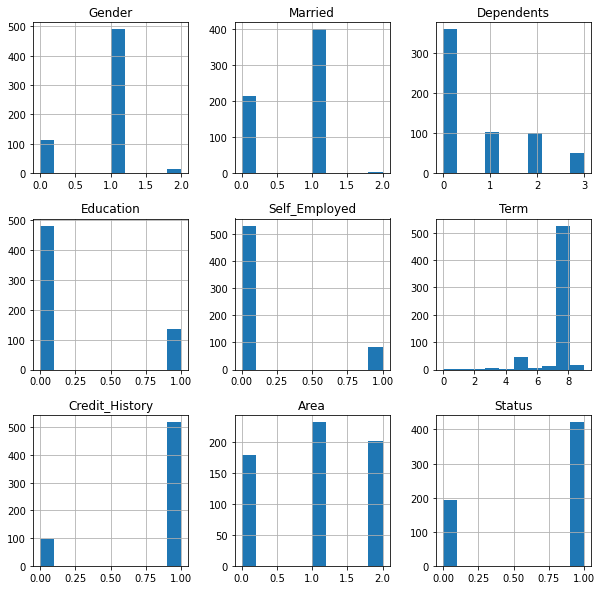

In [256]:
data.hist(figsize=(10, 10))

* Use describe statistic

In [257]:
data.describe().round()

,Gender,Married,Dependents,Education,Self_Employed,Term,Credit_History,Area,Status
count,614.0,614.0,614.0,614.0,614.0,614.0,614.0,614.0,614.0
mean,1.0,1.0,1.0,0.0,0.0,8.0,1.0,1.0,1.0
std,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0
50%,1.0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,0.0,0.0,8.0,1.0,2.0,1.0
max,2.0,2.0,3.0,1.0,1.0,9.0,1.0,2.0,1.0


* Use logistic Rregression, Tree algorithm and reduce dimension also create a new feature

#### Scaling

In [258]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
data_scaled.describe().round(2)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
count,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00
mean,0.42,0.33,0.25,0.22,0.13,0.50,0.56,0.50,0.85,0.85,0.52,0.69
std,0.21,0.24,0.34,0.41,0.34,0.31,0.42,0.32,0.12,0.36,0.39,0.46
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.00,0.00,0.00,0.00,0.21,0.22,0.22,0.89,1.00,0.00,0.00
50%,0.50,0.50,0.00,0.00,0.00,0.50,0.44,0.44,0.89,1.00,0.50,1.00
75%,0.50,0.50,0.33,0.00,0.00,0.79,1.00,0.78,0.89,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Training + Feature Selection and Dimensionality Reduction

#### Logistic Regression

In [259]:
X = data_scaled.drop('Status',axis=1)
y = data_scaled.Status

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)

In [261]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [262]:
score=r2_score(y_test,pred)
print(f"R2 score:{score}") 
print(f'Mean absolute error is {mean_absolute_error(y_test, pred)}')

R2 score:0.34073464912280704
Mean absolute error is 0.14054054054054055


#### Logistic Regression with RFE

##### checking most relevant features with chi2

In [263]:
selector = SelectKBest(chi2, k=2)
X_new = selector.fit_transform(X, y)
print(selector.feature_names_in_)
print(selector.pvalues_.round(2))
print(selector.get_support())

['Gender' 'Married' 'Dependents' 'Education' 'Self_Employed'
 'Applicant_Income' 'Coapplicant_Income' 'Loan_Amount' 'Term'
 'Credit_History' 'Area']
[0.94 0.31 0.87 0.06 0.93 0.9  0.33 0.87 0.99 0.   0.66]
[False False False  True False False False False False  True False]


In [264]:
model_rfe_lr = LogisticRegression(max_iter=1000)
rfe_lr = RFE(model_rfe_lr, n_features_to_select=2)
RFE_fit = rfe_lr.fit(X_train,y_train)
pred_rfe_lr = rfe_lr.predict(X_test)

In [265]:
print(X_train.columns[RFE_fit.get_support()])

Index(['Married', 'Credit_History'], dtype='object')


In [266]:
score_rfe_lr=r2_score(y_test,pred_rfe_lr)
print(f"R2 score:{score_rfe_lr}") 
print(f'Mean absolute error is {mean_absolute_error(y_test, pred_rfe_lr)}')

R2 score:0.39144736842105265
Mean absolute error is 0.12972972972972974


#### Random Forest Classifier

In [267]:
X2 = data.drop('Status',axis=1)
y2 = data.Status

In [268]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,shuffle=False)

In [269]:
model2 = RandomForestClassifier(max_depth=2, random_state=0)
model2.fit(X2_train, y2_train)
pred2 = model2.predict(X2_test)

In [270]:
score2=r2_score(y2_test,pred2)
print(f"R2 score:{score2}") 
print(f'Mean absolute error is {mean_absolute_error(y2_test, pred2)}')

R2 score:0.39144736842105265
Mean absolute error is 0.12972972972972974


#### Random Forest Classifier with RFE

##### checking most relevant features with chi2

In [271]:
selector = SelectKBest(chi2, k=2)
X2_new = selector.fit_transform(X2, y2)
print(selector.feature_names_in_)
print(selector.pvalues_.round(2))
print(selector.get_support())

['Gender' 'Married' 'Dependents' 'Education' 'Self_Employed'
 'Applicant_Income' 'Coapplicant_Income' 'Loan_Amount' 'Term'
 'Credit_History' 'Area']
[0.92 0.15 0.77 0.06 0.93 0.62 0.01 0.64 0.96 0.   0.54]
[False False False False False False  True False False  True False]


In [272]:
model_rf_rfe = RandomForestClassifier(max_depth=2, random_state=0)
rfe_rf = RFE(model_rf_rfe, n_features_to_select=2)
RFE_fit2 = rfe_rf.fit(X2_train,y2_train)

pred_rf_rfe = rfe_rf.predict(X2_test)

In [273]:
print(X2_train.columns[REF_fit2.get_support()])

Index(['Loan_Amount', 'Credit_History'], dtype='object')


In [274]:
score_rf_rfe=r2_score(y2_test,pred_rf_rfe)
print(f"R2 score:{score_rf_rfe}") 
print(f'Mean absolute error is {mean_absolute_error(y2_test, pred_rf_rfe)}')

R2 score:0.39144736842105265
Mean absolute error is 0.12972972972972974



* Explain the results

#### Distribution:
* Gender: probably negative binomial distribution (or poisson distribution?)
* Married: probably negative binomial distribution (or poisson distribution?)
* Dependents: not sure what type of distribution, skewed to the left 
* Education: bernoulli distribution because only 2 possible outcomes
* Self_Employed: bernoulli distribution because only 2 possible outcomes
* Term: not sure what type of distribution, but highly skewed to the left. When removing the outliers, everything except 360, so i decided not to remove outliers there.
* Credit_History: bernoulli distribution because only 2 possible outcomes
* Area: probably normal or uniform distribution. the differences are not big, but I think its more normal since for uniform all outcome have same probability 
* Status: bernoulli distribution because only 2 possible outcomes

#### Logistic Regression: 
* R2 score:0.3407
* Mean absolute error is 0.1405

##### with RFE:
* R2 score:0.3914
* Mean absolute error is 0.1297

##### Valuable features in LR by RFE:
* Married, Credit_History

##### Valuable features in LR by Chi2:
* Education, Credit History

#### Random Forest 
* R2 score:0.391
* Mean absolute error is 0.129

##### with RFE:
* R2 score:0.391
* Mean absolute error is 0.129

##### Valuable features in RF by RFE:
* Loan Amount, Credit History

##### Valuable features in RF by Chi2:
* Coapplicant_Income, Credit History


__________________________________________________________________

##### As a result, the score of Logistic Regression without RFE was the lowest (0.34)
##### The result of LR with RFE and results of Random Forest (with and without RFE) are the same and equal to 0.39 which is a little bit better
##### If analyzing which exactly features are considered most valuable, I think that RFE of RF was the most precise (Loan Amount and Credit History)